In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Flatten
from keras.models import Model, Sequential
import numpy as np
import os
import glob
from tqdm import tqdm
import manipulacion_midi
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [2]:
tiempos_previos=5                      #Numero de tiempos previos utilizados para el entrenamiento y la prediccion
longitud_minima=15                     #Tamaño minimo (en tiempos) que deben tener las canciones del conjunto de entrenamiento
carpeta_canciones='../canciones_entrenamiento'     #Carpeta donde estan las canciones el entrenamiento
modelo_guardado='mejor_modelo_convolucional.hdf5'  #Nombre del archivo donde se guardara el modelo entrenado

#Elimina los tiempos vacios antes de todas las canciones
def eliminar_zeros_iniciales(arr):
    i=0
    ceros=np.zeros_like(arr[0])
    tamano=np.size(arr,0)
    while np.array_equal(arr[i],ceros) and tamano!=1:
        arr=np.delete(arr,i, axis=0)
        tamano=tamano-1
    return arr

def leer_canciones(ruta):
    print('Cargando archivos...')
    archivos = glob.glob('{}/*.mid*'.format(ruta))
    archivos = np.array(np.sort(archivos))
    archivos = archivos.tolist()
    global canciones
    global numero_cancion
    canciones = []
    numero_cancion=0
    for f in tqdm(archivos):
        print(f)
        try:
            cancion = np.array(manipulacion_midi.midiToNoteStateMatrix(f))			#Convierte los archivos .mid a matrices 
            cancion=eliminar_zeros_iniciales(cancion)
            tam = np.array(cancion).shape[0]
            print(tam)
            if tam > longitud_minima:
                if(numero_cancion==0):
                    canciones=cancion
                    numero_cancion=numero_cancion+1
                else:
                    canciones= np.concatenate([canciones, cancion], axis=0)
                    numero_cancion=numero_cancion+1
        except Exception as e:
            raise e
    return canciones

#Convierte el arreglo 2D de entradas en un arreglo 3D para entrenar el sistema
def dimensionar(w):
    for t, val in enumerate(w):
        u[0, t] = val
    return u

In [3]:
#Cargar canciones
canciones = leer_canciones(carpeta_canciones)

print("Se cargaron {} canciones".format(numero_cancion))

Cargando archivos...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

canciones\K19d Piano Sonata Duet.mid
1761


  3%|██▊                                                                                | 1/30 [00:07<03:46,  7.80s/it]

canciones\K279 Piano sonata n01 1mov.mid
2204


  7%|█████▌                                                                             | 2/30 [00:15<03:34,  7.66s/it]

canciones\K279 Piano sonata n01 3mov.mid
1708


 10%|████████▎                                                                          | 3/30 [00:22<03:21,  7.46s/it]

canciones\K281 Piano Sonata n03 1mov.mid
2516


 13%|███████████                                                                        | 4/30 [00:27<03:01,  6.98s/it]

canciones\K281 Piano Sonata n03 3mov.mid
2387


 17%|█████████████▊                                                                     | 5/30 [00:39<03:26,  8.27s/it]

canciones\K309 Piano Sonata n10 1mov.mid
4957


 20%|████████████████▌                                                                  | 6/30 [01:00<04:55, 12.30s/it]

canciones\K309 Piano Sonata n10 3mov.mid
2014


 23%|███████████████████▎                                                               | 7/30 [01:10<04:21, 11.35s/it]

canciones\K330 Piano Sonata n10 1mov.mid
2399


 27%|██████████████████████▏                                                            | 8/30 [01:17<03:45, 10.23s/it]

canciones\K330 Piano Sonata n10 3mov.mid
2731


 30%|████████████████████████▉                                                          | 9/30 [01:30<03:49, 10.95s/it]

canciones\K331 Piano sonata n11 3mov.mid
1785


 33%|███████████████████████████▎                                                      | 10/30 [01:34<02:55,  8.78s/it]

canciones\K333 Piano Sonata n13 1mov.mid
5281


 37%|██████████████████████████████                                                    | 11/30 [01:59<04:21, 13.77s/it]

canciones\K333 Piano Sonata n13 3mov.mid
3153


 40%|████████████████████████████████▊                                                 | 12/30 [02:08<03:40, 12.24s/it]

canciones\K358 Piano Sonata 4 Hands.mid
1777


 43%|███████████████████████████████████▌                                              | 13/30 [02:11<02:41,  9.49s/it]

canciones\K381 Piano Sonata 4 Hands.mid
1553


 47%|██████████████████████████████████████▎                                           | 14/30 [02:14<02:01,  7.60s/it]

canciones\K521 Piano Sonata 4 Hands.mid
3649


 50%|█████████████████████████████████████████                                         | 15/30 [02:21<01:51,  7.45s/it]

canciones\K545 Piano Sonata.mid
2369


 53%|███████████████████████████████████████████▋                                      | 16/30 [02:25<01:31,  6.56s/it]

canciones\K570 Piano Sonata 2mov.mid
1265


 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:28<01:08,  5.24s/it]

canciones\K570 Piano Sonata 3mov.mid
1939


 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:30<00:52,  4.39s/it]

canciones\Piano Sonata n01 K279.mid
1617


 63%|███████████████████████████████████████████████████▉                              | 19/30 [02:35<00:50,  4.59s/it]

canciones\Piano Sonata n03 K281.mid
1745


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [02:41<00:48,  4.90s/it]

canciones\Piano Sonata n04 K282.mid
1153


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:45<00:42,  4.72s/it]

canciones\Piano Sonata n06 K284.mid
2033


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [02:54<00:47,  5.98s/it]

canciones\Piano Sonata n07 K309.mid
2481


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [03:08<00:58,  8.32s/it]

canciones\Piano Sonata n08 K311.mid
3281


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [03:18<00:53,  9.00s/it]

canciones\Piano Sonata n09 K310.mid
2129


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [03:26<00:43,  8.64s/it]

canciones\Piano Sonata n10 K330.mid
2401


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [03:34<00:33,  8.39s/it]

canciones\Piano Sonata n13 K333.mid
2645


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [03:42<00:24,  8.20s/it]

canciones\Piano Sonata n14 K457.mid
4897


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [03:57<00:20, 10.32s/it]

canciones\Piano Sonata n15 K593-494.mid
3829


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [04:08<00:10, 10.53s/it]

canciones\Piano Sonata n16 K545.mid
1185


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:12<00:00,  8.44s/it]


Se cargaron 30 canciones


In [4]:
len(canciones)

74844

In [5]:
#Definir la red neuronal 
filtros=40

model = Sequential()
model.add(Reshape((tiempos_previos, 156, 1), input_shape=(tiempos_previos, 156)))
model.add(Conv2D(kernel_size=4, filters=filtros, strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(600))
model.add(Dense(156))
model.add(Activation('sigmoid', name='sigmoid'))


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 5, 156, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 156, 40)        680       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 78, 40)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               5616600   
_________________________________________________________________
dense_2 (Dense)              (None, 156)               93756     
_________________________________________________________________
sigmoid (Activation)         (None, 156)               0         
Total para

In [7]:
#Cargar modelo guardado

model.load_weights(modelo_guardado)

In [8]:
#Define como se guarda el modelo

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['binary_crossentropy'])
checkpoint = ModelCheckpoint(modelo_guardado, monitor='binary_crossentropy', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [9]:
#Dividir las canciones en dos arreglos, uno para los tiempos previos y otro para tiempo de salida  

sentences=[]
next_values=[]
for i in range(0, len(canciones) - tiempos_previos):
    sentences.append(canciones[i: i + tiempos_previos])
    next_values.append(canciones[i + tiempos_previos])

In [10]:
#Convertir conjuntos de tiempos previos en un arreglo tridimensional 

X = np.zeros((len(sentences), tiempos_previos, 156), dtype=np.int32)
for i, sentence in enumerate(sentences):
    for t, val in enumerate(sentence):
        X[i, t] = val
y = np.asarray(next_values)

In [12]:
#Entrenar modelo

model.fit(X, y, epochs=10000, batch_size=200, callbacks=callbacks_list)

Epoch 1/10000
74839/74839 [==============================] - 185s - loss: 0.0766 - binary_crossentropy: 0.0766   
Epoch 2/10000


29200/74839 [==========>...................] - ETA: 179s - loss: 0.0582 - binary_crossentropy: 0.058 - ETA: 181s - loss: 0.0576 - binary_crossentropy: 0.057 - ETA: 185s - loss: 0.0581 - binary_crossentropy: 0.058 - ETA: 185s - loss: 0.0565 - binary_crossentropy: 0.056 - ETA: 183s - loss: 0.0572 - binary_crossentropy: 0.057 - ETA: 182s - loss: 0.0576 - binary_crossentropy: 0.057 - ETA: 181s - loss: 0.0582 - binary_crossentropy: 0.058 - ETA: 180s - loss: 0.0581 - binary_crossentropy: 0.058 - ETA: 180s - loss: 0.0582 - binary_crossentropy: 0.058 - ETA: 180s - loss: 0.0582 - binary_crossentropy: 0.058 - ETA: 178s - loss: 0.0582 - binary_crossentropy: 0.058 - ETA: 178s - loss: 0.0586 - binary_crossentropy: 0.058 - ETA: 177s - loss: 0.0584 - binary_crossentropy: 0.058 - ETA: 176s - loss: 0.0586 - binary_crossentropy: 0.058 - ETA: 175s - loss: 0.0587 - binary_crossentropy: 0.058 - ETA: 175s - loss: 0.0589 - binary_crossentropy: 0.058 - ETA: 174s - loss: 0.0589 - binary_crossentropy: 0.058 - E

74839/74839 [==============================] - 182s - loss: 0.0581 - binary_crossentropy: 0.0581   
Epoch 3/10000
74839/74839 [==============================] - 188s - loss: 0.0548 - binary_crossentropy: 0.0548   
Epoch 4/10000


29200/74839 [==========>...................] - ETA: 210s - loss: 0.0539 - binary_crossentropy: 0.053 - ETA: 214s - loss: 0.0514 - binary_crossentropy: 0.051 - ETA: 211s - loss: 0.0531 - binary_crossentropy: 0.053 - ETA: 205s - loss: 0.0540 - binary_crossentropy: 0.054 - ETA: 204s - loss: 0.0540 - binary_crossentropy: 0.054 - ETA: 206s - loss: 0.0535 - binary_crossentropy: 0.053 - ETA: 206s - loss: 0.0536 - binary_crossentropy: 0.053 - ETA: 206s - loss: 0.0537 - binary_crossentropy: 0.053 - ETA: 204s - loss: 0.0537 - binary_crossentropy: 0.053 - ETA: 203s - loss: 0.0541 - binary_crossentropy: 0.054 - ETA: 204s - loss: 0.0540 - binary_crossentropy: 0.054 - ETA: 205s - loss: 0.0539 - binary_crossentropy: 0.053 - ETA: 206s - loss: 0.0540 - binary_crossentropy: 0.054 - ETA: 207s - loss: 0.0540 - binary_crossentropy: 0.054 - ETA: 206s - loss: 0.0537 - binary_crossentropy: 0.053 - ETA: 208s - loss: 0.0537 - binary_crossentropy: 0.053 - ETA: 209s - loss: 0.0537 - binary_crossentropy: 0.053 - E

74839/74839 [==============================] - 215s - loss: 0.0527 - binary_crossentropy: 0.0527   
Epoch 5/10000
74839/74839 [==============================] - 213s - loss: 0.0509 - binary_crossentropy: 0.0509   
Epoch 6/10000


29200/74839 [==========>...................] - ETA: 184s - loss: 0.0473 - binary_crossentropy: 0.047 - ETA: 186s - loss: 0.0484 - binary_crossentropy: 0.048 - ETA: 194s - loss: 0.0502 - binary_crossentropy: 0.050 - ETA: 192s - loss: 0.0483 - binary_crossentropy: 0.048 - ETA: 194s - loss: 0.0489 - binary_crossentropy: 0.048 - ETA: 194s - loss: 0.0486 - binary_crossentropy: 0.048 - ETA: 194s - loss: 0.0487 - binary_crossentropy: 0.048 - ETA: 193s - loss: 0.0488 - binary_crossentropy: 0.048 - ETA: 192s - loss: 0.0485 - binary_crossentropy: 0.048 - ETA: 191s - loss: 0.0491 - binary_crossentropy: 0.049 - ETA: 190s - loss: 0.0488 - binary_crossentropy: 0.048 - ETA: 190s - loss: 0.0489 - binary_crossentropy: 0.048 - ETA: 189s - loss: 0.0486 - binary_crossentropy: 0.048 - ETA: 188s - loss: 0.0486 - binary_crossentropy: 0.048 - ETA: 188s - loss: 0.0486 - binary_crossentropy: 0.048 - ETA: 187s - loss: 0.0490 - binary_crossentropy: 0.049 - ETA: 186s - loss: 0.0492 - binary_crossentropy: 0.049 - E

74839/74839 [==============================] - 224s - loss: 0.0493 - binary_crossentropy: 0.0493   
Epoch 7/10000
74839/74839 [==============================] - 193s - loss: 0.0481 - binary_crossentropy: 0.0481   
Epoch 8/10000


29200/74839 [==========>...................] - ETA: 172s - loss: 0.0484 - binary_crossentropy: 0.048 - ETA: 176s - loss: 0.0457 - binary_crossentropy: 0.045 - ETA: 185s - loss: 0.0471 - binary_crossentropy: 0.047 - ETA: 191s - loss: 0.0460 - binary_crossentropy: 0.046 - ETA: 187s - loss: 0.0465 - binary_crossentropy: 0.046 - ETA: 184s - loss: 0.0462 - binary_crossentropy: 0.046 - ETA: 182s - loss: 0.0460 - binary_crossentropy: 0.046 - ETA: 181s - loss: 0.0462 - binary_crossentropy: 0.046 - ETA: 179s - loss: 0.0465 - binary_crossentropy: 0.046 - ETA: 178s - loss: 0.0469 - binary_crossentropy: 0.046 - ETA: 177s - loss: 0.0467 - binary_crossentropy: 0.046 - ETA: 176s - loss: 0.0468 - binary_crossentropy: 0.046 - ETA: 206s - loss: 0.0467 - binary_crossentropy: 0.046 - ETA: 218s - loss: 0.0468 - binary_crossentropy: 0.046 - ETA: 214s - loss: 0.0468 - binary_crossentropy: 0.046 - ETA: 211s - loss: 0.0469 - binary_crossentropy: 0.046 - ETA: 208s - loss: 0.0467 - binary_crossentropy: 0.046 - E

74839/74839 [==============================] - 197s - loss: 0.0470 - binary_crossentropy: 0.0470   
Epoch 9/10000
74839/74839 [==============================] - 213s - loss: 0.0459 - binary_crossentropy: 0.0459   
Epoch 10/10000


29200/74839 [==========>...................] - ETA: 173s - loss: 0.0391 - binary_crossentropy: 0.039 - ETA: 172s - loss: 0.0425 - binary_crossentropy: 0.042 - ETA: 172s - loss: 0.0432 - binary_crossentropy: 0.043 - ETA: 175s - loss: 0.0443 - binary_crossentropy: 0.044 - ETA: 178s - loss: 0.0446 - binary_crossentropy: 0.044 - ETA: 181s - loss: 0.0440 - binary_crossentropy: 0.044 - ETA: 183s - loss: 0.0437 - binary_crossentropy: 0.043 - ETA: 183s - loss: 0.0438 - binary_crossentropy: 0.043 - ETA: 183s - loss: 0.0437 - binary_crossentropy: 0.043 - ETA: 182s - loss: 0.0440 - binary_crossentropy: 0.044 - ETA: 181s - loss: 0.0439 - binary_crossentropy: 0.043 - ETA: 180s - loss: 0.0442 - binary_crossentropy: 0.044 - ETA: 179s - loss: 0.0444 - binary_crossentropy: 0.044 - ETA: 178s - loss: 0.0445 - binary_crossentropy: 0.044 - ETA: 178s - loss: 0.0446 - binary_crossentropy: 0.044 - ETA: 177s - loss: 0.0447 - binary_crossentropy: 0.044 - ETA: 176s - loss: 0.0445 - binary_crossentropy: 0.044 - E

74839/74839 [==============================] - 207s - loss: 0.0450 - binary_crossentropy: 0.0450   
Epoch 11/10000
74839/74839 [==============================] - 208s - loss: 0.0441 - binary_crossentropy: 0.0441   
Epoch 12/10000


29200/74839 [==========>...................] - ETA: 173s - loss: 0.0427 - binary_crossentropy: 0.042 - ETA: 182s - loss: 0.0428 - binary_crossentropy: 0.042 - ETA: 183s - loss: 0.0422 - binary_crossentropy: 0.042 - ETA: 187s - loss: 0.0424 - binary_crossentropy: 0.042 - ETA: 188s - loss: 0.0426 - binary_crossentropy: 0.042 - ETA: 190s - loss: 0.0431 - binary_crossentropy: 0.043 - ETA: 188s - loss: 0.0428 - binary_crossentropy: 0.042 - ETA: 187s - loss: 0.0427 - binary_crossentropy: 0.042 - ETA: 185s - loss: 0.0426 - binary_crossentropy: 0.042 - ETA: 185s - loss: 0.0427 - binary_crossentropy: 0.042 - ETA: 185s - loss: 0.0428 - binary_crossentropy: 0.042 - ETA: 186s - loss: 0.0428 - binary_crossentropy: 0.042 - ETA: 187s - loss: 0.0427 - binary_crossentropy: 0.042 - ETA: 216s - loss: 0.0427 - binary_crossentropy: 0.042 - ETA: 219s - loss: 0.0429 - binary_crossentropy: 0.042 - ETA: 216s - loss: 0.0425 - binary_crossentropy: 0.042 - ETA: 215s - loss: 0.0427 - binary_crossentropy: 0.042 - E

74839/74839 [==============================] - 207s - loss: 0.0434 - binary_crossentropy: 0.0434   
Epoch 13/10000
74839/74839 [==============================] - 209s - loss: 0.0427 - binary_crossentropy: 0.0427   
Epoch 14/10000


29200/74839 [==========>...................] - ETA: 173s - loss: 0.0384 - binary_crossentropy: 0.038 - ETA: 176s - loss: 0.0377 - binary_crossentropy: 0.037 - ETA: 173s - loss: 0.0377 - binary_crossentropy: 0.037 - ETA: 176s - loss: 0.0379 - binary_crossentropy: 0.037 - ETA: 176s - loss: 0.0385 - binary_crossentropy: 0.038 - ETA: 177s - loss: 0.0385 - binary_crossentropy: 0.038 - ETA: 181s - loss: 0.0383 - binary_crossentropy: 0.038 - ETA: 180s - loss: 0.0382 - binary_crossentropy: 0.038 - ETA: 180s - loss: 0.0392 - binary_crossentropy: 0.039 - ETA: 180s - loss: 0.0391 - binary_crossentropy: 0.039 - ETA: 180s - loss: 0.0393 - binary_crossentropy: 0.039 - ETA: 180s - loss: 0.0392 - binary_crossentropy: 0.039 - ETA: 179s - loss: 0.0391 - binary_crossentropy: 0.039 - ETA: 178s - loss: 0.0396 - binary_crossentropy: 0.039 - ETA: 177s - loss: 0.0396 - binary_crossentropy: 0.039 - ETA: 201s - loss: 0.0397 - binary_crossentropy: 0.039 - ETA: 207s - loss: 0.0397 - binary_crossentropy: 0.039 - E

74839/74839 [==============================] - 205s - loss: 0.0420 - binary_crossentropy: 0.0420   
Epoch 15/10000
74839/74839 [==============================] - 202s - loss: 0.0414 - binary_crossentropy: 0.0414   
Epoch 16/10000


29200/74839 [==========>...................] - ETA: 181s - loss: 0.0423 - binary_crossentropy: 0.042 - ETA: 182s - loss: 0.0408 - binary_crossentropy: 0.040 - ETA: 183s - loss: 0.0400 - binary_crossentropy: 0.040 - ETA: 182s - loss: 0.0402 - binary_crossentropy: 0.040 - ETA: 186s - loss: 0.0405 - binary_crossentropy: 0.040 - ETA: 193s - loss: 0.0398 - binary_crossentropy: 0.039 - ETA: 252s - loss: 0.0397 - binary_crossentropy: 0.039 - ETA: 251s - loss: 0.0394 - binary_crossentropy: 0.039 - ETA: 242s - loss: 0.0394 - binary_crossentropy: 0.039 - ETA: 234s - loss: 0.0390 - binary_crossentropy: 0.039 - ETA: 227s - loss: 0.0388 - binary_crossentropy: 0.038 - ETA: 222s - loss: 0.0387 - binary_crossentropy: 0.038 - ETA: 217s - loss: 0.0389 - binary_crossentropy: 0.038 - ETA: 213s - loss: 0.0390 - binary_crossentropy: 0.039 - ETA: 209s - loss: 0.0390 - binary_crossentropy: 0.039 - ETA: 206s - loss: 0.0391 - binary_crossentropy: 0.039 - ETA: 203s - loss: 0.0392 - binary_crossentropy: 0.039 - E

74839/74839 [==============================] - 202s - loss: 0.0408 - binary_crossentropy: 0.0408   
Epoch 17/10000
74839/74839 [==============================] - 187s - loss: 0.0403 - binary_crossentropy: 0.0403   
Epoch 18/10000


29200/74839 [==========>...................] - ETA: 177s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 173s - loss: 0.0379 - binary_crossentropy: 0.037 - ETA: 178s - loss: 0.0377 - binary_crossentropy: 0.037 - ETA: 180s - loss: 0.0366 - binary_crossentropy: 0.036 - ETA: 183s - loss: 0.0362 - binary_crossentropy: 0.036 - ETA: 185s - loss: 0.0359 - binary_crossentropy: 0.035 - ETA: 183s - loss: 0.0361 - binary_crossentropy: 0.036 - ETA: 181s - loss: 0.0370 - binary_crossentropy: 0.037 - ETA: 180s - loss: 0.0373 - binary_crossentropy: 0.037 - ETA: 178s - loss: 0.0372 - binary_crossentropy: 0.037 - ETA: 176s - loss: 0.0375 - binary_crossentropy: 0.037 - ETA: 175s - loss: 0.0376 - binary_crossentropy: 0.037 - ETA: 175s - loss: 0.0377 - binary_crossentropy: 0.037 - ETA: 175s - loss: 0.0377 - binary_crossentropy: 0.037 - ETA: 174s - loss: 0.0379 - binary_crossentropy: 0.037 - ETA: 174s - loss: 0.0381 - binary_crossentropy: 0.038 - ETA: 174s - loss: 0.0382 - binary_crossentropy: 0.038 - E

74839/74839 [==============================] - 188s - loss: 0.0398 - binary_crossentropy: 0.0398   
Epoch 19/10000
74839/74839 [==============================] - 192s - loss: 0.0394 - binary_crossentropy: 0.0394   
Epoch 20/10000


29200/74839 [==========>...................] - ETA: 182s - loss: 0.0385 - binary_crossentropy: 0.038 - ETA: 178s - loss: 0.0375 - binary_crossentropy: 0.037 - ETA: 179s - loss: 0.0393 - binary_crossentropy: 0.039 - ETA: 183s - loss: 0.0388 - binary_crossentropy: 0.038 - ETA: 185s - loss: 0.0376 - binary_crossentropy: 0.037 - ETA: 183s - loss: 0.0376 - binary_crossentropy: 0.037 - ETA: 182s - loss: 0.0374 - binary_crossentropy: 0.037 - ETA: 183s - loss: 0.0370 - binary_crossentropy: 0.037 - ETA: 181s - loss: 0.0371 - binary_crossentropy: 0.037 - ETA: 180s - loss: 0.0371 - binary_crossentropy: 0.037 - ETA: 179s - loss: 0.0376 - binary_crossentropy: 0.037 - ETA: 179s - loss: 0.0379 - binary_crossentropy: 0.037 - ETA: 180s - loss: 0.0380 - binary_crossentropy: 0.038 - ETA: 180s - loss: 0.0381 - binary_crossentropy: 0.038 - ETA: 179s - loss: 0.0382 - binary_crossentropy: 0.038 - ETA: 179s - loss: 0.0380 - binary_crossentropy: 0.038 - ETA: 178s - loss: 0.0379 - binary_crossentropy: 0.037 - E

74839/74839 [==============================] - 186s - loss: 0.0389 - binary_crossentropy: 0.0389   
Epoch 21/10000
74839/74839 [==============================] - 193s - loss: 0.0385 - binary_crossentropy: 0.0385   
Epoch 22/10000


29200/74839 [==========>...................] - ETA: 172s - loss: 0.0355 - binary_crossentropy: 0.035 - ETA: 179s - loss: 0.0346 - binary_crossentropy: 0.034 - ETA: 186s - loss: 0.0348 - binary_crossentropy: 0.034 - ETA: 192s - loss: 0.0344 - binary_crossentropy: 0.034 - ETA: 196s - loss: 0.0345 - binary_crossentropy: 0.034 - ETA: 192s - loss: 0.0344 - binary_crossentropy: 0.034 - ETA: 190s - loss: 0.0350 - binary_crossentropy: 0.035 - ETA: 188s - loss: 0.0354 - binary_crossentropy: 0.035 - ETA: 186s - loss: 0.0359 - binary_crossentropy: 0.035 - ETA: 184s - loss: 0.0362 - binary_crossentropy: 0.036 - ETA: 183s - loss: 0.0361 - binary_crossentropy: 0.036 - ETA: 181s - loss: 0.0362 - binary_crossentropy: 0.036 - ETA: 180s - loss: 0.0363 - binary_crossentropy: 0.036 - ETA: 180s - loss: 0.0363 - binary_crossentropy: 0.036 - ETA: 180s - loss: 0.0360 - binary_crossentropy: 0.036 - ETA: 179s - loss: 0.0359 - binary_crossentropy: 0.035 - ETA: 178s - loss: 0.0362 - binary_crossentropy: 0.036 - E

74839/74839 [==============================] - 188s - loss: 0.0381 - binary_crossentropy: 0.0381   
Epoch 23/10000
74839/74839 [==============================] - 189s - loss: 0.0377 - binary_crossentropy: 0.0377   
Epoch 24/10000


29200/74839 [==========>...................] - ETA: 182s - loss: 0.0387 - binary_crossentropy: 0.038 - ETA: 194s - loss: 0.0395 - binary_crossentropy: 0.039 - ETA: 192s - loss: 0.0390 - binary_crossentropy: 0.039 - ETA: 186s - loss: 0.0378 - binary_crossentropy: 0.037 - ETA: 184s - loss: 0.0366 - binary_crossentropy: 0.036 - ETA: 181s - loss: 0.0364 - binary_crossentropy: 0.036 - ETA: 181s - loss: 0.0362 - binary_crossentropy: 0.036 - ETA: 179s - loss: 0.0362 - binary_crossentropy: 0.036 - ETA: 178s - loss: 0.0359 - binary_crossentropy: 0.035 - ETA: 178s - loss: 0.0359 - binary_crossentropy: 0.035 - ETA: 176s - loss: 0.0355 - binary_crossentropy: 0.035 - ETA: 175s - loss: 0.0354 - binary_crossentropy: 0.035 - ETA: 175s - loss: 0.0355 - binary_crossentropy: 0.035 - ETA: 174s - loss: 0.0356 - binary_crossentropy: 0.035 - ETA: 173s - loss: 0.0353 - binary_crossentropy: 0.035 - ETA: 173s - loss: 0.0356 - binary_crossentropy: 0.035 - ETA: 172s - loss: 0.0357 - binary_crossentropy: 0.035 - E

74839/74839 [==============================] - 192s - loss: 0.0373 - binary_crossentropy: 0.0373   
Epoch 25/10000
74839/74839 [==============================] - 198s - loss: 0.0370 - binary_crossentropy: 0.0370   
Epoch 26/10000


29200/74839 [==========>...................] - ETA: 174s - loss: 0.0368 - binary_crossentropy: 0.036 - ETA: 175s - loss: 0.0353 - binary_crossentropy: 0.035 - ETA: 176s - loss: 0.0350 - binary_crossentropy: 0.035 - ETA: 176s - loss: 0.0341 - binary_crossentropy: 0.034 - ETA: 181s - loss: 0.0345 - binary_crossentropy: 0.034 - ETA: 182s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 181s - loss: 0.0344 - binary_crossentropy: 0.034 - ETA: 180s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 181s - loss: 0.0345 - binary_crossentropy: 0.034 - ETA: 181s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 179s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 178s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 176s - loss: 0.0342 - binary_crossentropy: 0.034 - ETA: 175s - loss: 0.0341 - binary_crossentropy: 0.034 - ETA: 174s - loss: 0.0341 - binary_crossentropy: 0.034 - ETA: 173s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 173s - loss: 0.0340 - binary_crossentropy: 0.034 - E

74839/74839 [==============================] - 202s - loss: 0.0367 - binary_crossentropy: 0.0367   
Epoch 27/10000
74839/74839 [==============================] - 208s - loss: 0.0364 - binary_crossentropy: 0.0364   
Epoch 28/10000


29200/74839 [==========>...................] - ETA: 606s - loss: 0.0330 - binary_crossentropy: 0.033 - ETA: 403s - loss: 0.0338 - binary_crossentropy: 0.033 - ETA: 344s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 305s - loss: 0.0337 - binary_crossentropy: 0.033 - ETA: 281s - loss: 0.0340 - binary_crossentropy: 0.034 - ETA: 265s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 253s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 243s - loss: 0.0341 - binary_crossentropy: 0.034 - ETA: 235s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 229s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 224s - loss: 0.0337 - binary_crossentropy: 0.033 - ETA: 218s - loss: 0.0338 - binary_crossentropy: 0.033 - ETA: 214s - loss: 0.0337 - binary_crossentropy: 0.033 - ETA: 211s - loss: 0.0336 - binary_crossentropy: 0.033 - ETA: 207s - loss: 0.0340 - binary_crossentropy: 0.034 - ETA: 205s - loss: 0.0337 - binary_crossentropy: 0.033 - ETA: 203s - loss: 0.0338 - binary_crossentropy: 0.033 - E

74839/74839 [==============================] - 209s - loss: 0.0361 - binary_crossentropy: 0.0361   
Epoch 29/10000
74839/74839 [==============================] - 212s - loss: 0.0359 - binary_crossentropy: 0.0359   
Epoch 30/10000


29200/74839 [==========>...................] - ETA: 187s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 188s - loss: 0.0322 - binary_crossentropy: 0.032 - ETA: 189s - loss: 0.0338 - binary_crossentropy: 0.033 - ETA: 188s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 188s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 192s - loss: 0.0342 - binary_crossentropy: 0.034 - ETA: 189s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 188s - loss: 0.0341 - binary_crossentropy: 0.034 - ETA: 187s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 185s - loss: 0.0338 - binary_crossentropy: 0.033 - ETA: 184s - loss: 0.0338 - binary_crossentropy: 0.033 - ETA: 183s - loss: 0.0337 - binary_crossentropy: 0.033 - ETA: 182s - loss: 0.0336 - binary_crossentropy: 0.033 - ETA: 181s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 181s - loss: 0.0339 - binary_crossentropy: 0.033 - ETA: 180s - loss: 0.0340 - binary_crossentropy: 0.034 - ETA: 180s - loss: 0.0341 - binary_crossentropy: 0.034 - E

74839/74839 [==============================] - 206s - loss: 0.0356 - binary_crossentropy: 0.0356   
Epoch 31/10000
74839/74839 [==============================] - 211s - loss: 0.0353 - binary_crossentropy: 0.0353   
Epoch 32/10000


29200/74839 [==========>...................] - ETA: 178s - loss: 0.0378 - binary_crossentropy: 0.037 - ETA: 181s - loss: 0.0352 - binary_crossentropy: 0.035 - ETA: 180s - loss: 0.0356 - binary_crossentropy: 0.035 - ETA: 181s - loss: 0.0349 - binary_crossentropy: 0.034 - ETA: 185s - loss: 0.0354 - binary_crossentropy: 0.035 - ETA: 189s - loss: 0.0355 - binary_crossentropy: 0.035 - ETA: 189s - loss: 0.0349 - binary_crossentropy: 0.034 - ETA: 188s - loss: 0.0345 - binary_crossentropy: 0.034 - ETA: 187s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 186s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 185s - loss: 0.0341 - binary_crossentropy: 0.034 - ETA: 184s - loss: 0.0342 - binary_crossentropy: 0.034 - ETA: 182s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 181s - loss: 0.0343 - binary_crossentropy: 0.034 - ETA: 180s - loss: 0.0344 - binary_crossentropy: 0.034 - ETA: 179s - loss: 0.0345 - binary_crossentropy: 0.034 - ETA: 178s - loss: 0.0346 - binary_crossentropy: 0.034 - E

74839/74839 [==============================] - 211s - loss: 0.0351 - binary_crossentropy: 0.0351   
Epoch 33/10000
74839/74839 [==============================] - 217s - loss: 0.0349 - binary_crossentropy: 0.0349   
Epoch 34/10000


29200/74839 [==========>...................] - ETA: 449s - loss: 0.0340 - binary_crossentropy: 0.034 - ETA: 314s - loss: 0.0323 - binary_crossentropy: 0.032 - ETA: 272s - loss: 0.0320 - binary_crossentropy: 0.032 - ETA: 252s - loss: 0.0318 - binary_crossentropy: 0.031 - ETA: 242s - loss: 0.0331 - binary_crossentropy: 0.033 - ETA: 234s - loss: 0.0330 - binary_crossentropy: 0.033 - ETA: 225s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 219s - loss: 0.0325 - binary_crossentropy: 0.032 - ETA: 215s - loss: 0.0328 - binary_crossentropy: 0.032 - ETA: 212s - loss: 0.0324 - binary_crossentropy: 0.032 - ETA: 208s - loss: 0.0324 - binary_crossentropy: 0.032 - ETA: 207s - loss: 0.0323 - binary_crossentropy: 0.032 - ETA: 204s - loss: 0.0325 - binary_crossentropy: 0.032 - ETA: 201s - loss: 0.0326 - binary_crossentropy: 0.032 - ETA: 200s - loss: 0.0326 - binary_crossentropy: 0.032 - ETA: 198s - loss: 0.0328 - binary_crossentropy: 0.032 - ETA: 196s - loss: 0.0329 - binary_crossentropy: 0.032 - E

74839/74839 [==============================] - 213s - loss: 0.0346 - binary_crossentropy: 0.0346   
Epoch 35/10000
74839/74839 [==============================] - 222s - loss: 0.0344 - binary_crossentropy: 0.0344   
Epoch 36/10000


29200/74839 [==========>...................] - ETA: 190s - loss: 0.0314 - binary_crossentropy: 0.031 - ETA: 187s - loss: 0.0328 - binary_crossentropy: 0.032 - ETA: 192s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 191s - loss: 0.0325 - binary_crossentropy: 0.032 - ETA: 196s - loss: 0.0331 - binary_crossentropy: 0.033 - ETA: 195s - loss: 0.0325 - binary_crossentropy: 0.032 - ETA: 193s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 192s - loss: 0.0332 - binary_crossentropy: 0.033 - ETA: 194s - loss: 0.0331 - binary_crossentropy: 0.033 - ETA: 233s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 236s - loss: 0.0327 - binary_crossentropy: 0.032 - ETA: 231s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 226s - loss: 0.0331 - binary_crossentropy: 0.033 - ETA: 222s - loss: 0.0330 - binary_crossentropy: 0.033 - ETA: 219s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 217s - loss: 0.0331 - binary_crossentropy: 0.033 - ETA: 214s - loss: 0.0329 - binary_crossentropy: 0.032 - E

74839/74839 [==============================] - 214s - loss: 0.0342 - binary_crossentropy: 0.0342   
Epoch 37/10000
74839/74839 [==============================] - 214s - loss: 0.0341 - binary_crossentropy: 0.0341   
Epoch 38/10000


29200/74839 [==========>...................] - ETA: 176s - loss: 0.0316 - binary_crossentropy: 0.031 - ETA: 181s - loss: 0.0314 - binary_crossentropy: 0.031 - ETA: 183s - loss: 0.0317 - binary_crossentropy: 0.031 - ETA: 187s - loss: 0.0304 - binary_crossentropy: 0.030 - ETA: 186s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 191s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 188s - loss: 0.0317 - binary_crossentropy: 0.031 - ETA: 188s - loss: 0.0322 - binary_crossentropy: 0.032 - ETA: 187s - loss: 0.0325 - binary_crossentropy: 0.032 - ETA: 187s - loss: 0.0330 - binary_crossentropy: 0.033 - ETA: 187s - loss: 0.0328 - binary_crossentropy: 0.032 - ETA: 186s - loss: 0.0326 - binary_crossentropy: 0.032 - ETA: 185s - loss: 0.0326 - binary_crossentropy: 0.032 - ETA: 184s - loss: 0.0326 - binary_crossentropy: 0.032 - ETA: 183s - loss: 0.0325 - binary_crossentropy: 0.032 - ETA: 183s - loss: 0.0327 - binary_crossentropy: 0.032 - ETA: 182s - loss: 0.0326 - binary_crossentropy: 0.032 - E

74839/74839 [==============================] - 213s - loss: 0.0339 - binary_crossentropy: 0.0339   
Epoch 39/10000
74839/74839 [==============================] - 210s - loss: 0.0337 - binary_crossentropy: 0.0337   
Epoch 40/10000


29200/74839 [==========>...................] - ETA: 177s - loss: 0.0287 - binary_crossentropy: 0.028 - ETA: 180s - loss: 0.0315 - binary_crossentropy: 0.031 - ETA: 185s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 187s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 193s - loss: 0.0316 - binary_crossentropy: 0.031 - ETA: 192s - loss: 0.0325 - binary_crossentropy: 0.032 - ETA: 191s - loss: 0.0322 - binary_crossentropy: 0.032 - ETA: 190s - loss: 0.0321 - binary_crossentropy: 0.032 - ETA: 188s - loss: 0.0320 - binary_crossentropy: 0.032 - ETA: 185s - loss: 0.0318 - binary_crossentropy: 0.031 - ETA: 218s - loss: 0.0320 - binary_crossentropy: 0.032 - ETA: 227s - loss: 0.0320 - binary_crossentropy: 0.032 - ETA: 223s - loss: 0.0321 - binary_crossentropy: 0.032 - ETA: 219s - loss: 0.0322 - binary_crossentropy: 0.032 - ETA: 216s - loss: 0.0321 - binary_crossentropy: 0.032 - ETA: 214s - loss: 0.0321 - binary_crossentropy: 0.032 - ETA: 211s - loss: 0.0320 - binary_crossentropy: 0.032 - E

74839/74839 [==============================] - 205s - loss: 0.0335 - binary_crossentropy: 0.0335   
Epoch 41/10000
74839/74839 [==============================] - 206s - loss: 0.0334 - binary_crossentropy: 0.0334   
Epoch 42/10000


29200/74839 [==========>...................] - ETA: 178s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 173s - loss: 0.0305 - binary_crossentropy: 0.030 - ETA: 174s - loss: 0.0304 - binary_crossentropy: 0.030 - ETA: 177s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 182s - loss: 0.0305 - binary_crossentropy: 0.030 - ETA: 186s - loss: 0.0316 - binary_crossentropy: 0.031 - ETA: 184s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 183s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 181s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 180s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 179s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 178s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 178s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 177s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 176s - loss: 0.0316 - binary_crossentropy: 0.031 - ETA: 175s - loss: 0.0315 - binary_crossentropy: 0.031 - ETA: 175s - loss: 0.0315 - binary_crossentropy: 0.031 - E

74839/74839 [==============================] - 204s - loss: 0.0332 - binary_crossentropy: 0.0332   
Epoch 43/10000
74839/74839 [==============================] - 203s - loss: 0.0331 - binary_crossentropy: 0.0331   
Epoch 44/10000


29200/74839 [==========>...................] - ETA: 182s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 190s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 190s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 195s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 189s - loss: 0.0305 - binary_crossentropy: 0.030 - ETA: 187s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 184s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 184s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 182s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 182s - loss: 0.0318 - binary_crossentropy: 0.031 - ETA: 181s - loss: 0.0319 - binary_crossentropy: 0.031 - ETA: 181s - loss: 0.0323 - binary_crossentropy: 0.032 - ETA: 180s - loss: 0.0321 - binary_crossentropy: 0.032 - ETA: 179s - loss: 0.0321 - binary_crossentropy: 0.032 - ETA: 178s - loss: 0.0321 - binary_crossentropy: 0.032 - ETA: 177s - loss: 0.0319 - binary_crossentropy: 0.031 - ETA: 176s - loss: 0.0322 - binary_crossentropy: 0.032 - E

74839/74839 [==============================] - 203s - loss: 0.0330 - binary_crossentropy: 0.0330   
Epoch 45/10000
74839/74839 [==============================] - 205s - loss: 0.0327 - binary_crossentropy: 0.0327   
Epoch 46/10000


29200/74839 [==========>...................] - ETA: 166s - loss: 0.0284 - binary_crossentropy: 0.028 - ETA: 170s - loss: 0.0307 - binary_crossentropy: 0.030 - ETA: 171s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 177s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 181s - loss: 0.0315 - binary_crossentropy: 0.031 - ETA: 183s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 181s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 179s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 180s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 179s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 178s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 177s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 176s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 175s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 175s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 175s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 174s - loss: 0.0309 - binary_crossentropy: 0.030 - E

74839/74839 [==============================] - 203s - loss: 0.0326 - binary_crossentropy: 0.0326   
Epoch 47/10000
74839/74839 [==============================] - 205s - loss: 0.0325 - binary_crossentropy: 0.0325   
Epoch 48/10000


29200/74839 [==========>...................] - ETA: 169s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 176s - loss: 0.0330 - binary_crossentropy: 0.033 - ETA: 178s - loss: 0.0329 - binary_crossentropy: 0.032 - ETA: 180s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 180s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 184s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 183s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 183s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 183s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 183s - loss: 0.0305 - binary_crossentropy: 0.030 - ETA: 182s - loss: 0.0304 - binary_crossentropy: 0.030 - ETA: 181s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 180s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 179s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 179s - loss: 0.0307 - binary_crossentropy: 0.030 - ETA: 178s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 177s - loss: 0.0309 - binary_crossentropy: 0.030 - E

74839/74839 [==============================] - 205s - loss: 0.0323 - binary_crossentropy: 0.0323   
Epoch 49/10000
74839/74839 [==============================] - 205s - loss: 0.0322 - binary_crossentropy: 0.0322   
Epoch 50/10000


29200/74839 [==========>...................] - ETA: 175s - loss: 0.0334 - binary_crossentropy: 0.033 - ETA: 175s - loss: 0.0333 - binary_crossentropy: 0.033 - ETA: 179s - loss: 0.0315 - binary_crossentropy: 0.031 - ETA: 184s - loss: 0.0322 - binary_crossentropy: 0.032 - ETA: 185s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 183s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 183s - loss: 0.0304 - binary_crossentropy: 0.030 - ETA: 184s - loss: 0.0304 - binary_crossentropy: 0.030 - ETA: 184s - loss: 0.0307 - binary_crossentropy: 0.030 - ETA: 184s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 183s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 182s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 181s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 180s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 178s - loss: 0.0307 - binary_crossentropy: 0.030 - ETA: 177s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 176s - loss: 0.0310 - binary_crossentropy: 0.031 - E

74839/74839 [==============================] - 203s - loss: 0.0320 - binary_crossentropy: 0.0320   
Epoch 51/10000
74839/74839 [==============================] - 201s - loss: 0.0320 - binary_crossentropy: 0.0320   
Epoch 52/10000


29200/74839 [==========>...................] - ETA: 177s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 181s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 182s - loss: 0.0291 - binary_crossentropy: 0.029 - ETA: 186s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 190s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 187s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 185s - loss: 0.0301 - binary_crossentropy: 0.030 - ETA: 184s - loss: 0.0302 - binary_crossentropy: 0.030 - ETA: 182s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 181s - loss: 0.0309 - binary_crossentropy: 0.030 - ETA: 180s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 206s - loss: 0.0307 - binary_crossentropy: 0.030 - ETA: 220s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 216s - loss: 0.0307 - binary_crossentropy: 0.030 - ETA: 212s - loss: 0.0308 - binary_crossentropy: 0.030 - ETA: 209s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 206s - loss: 0.0305 - binary_crossentropy: 0.030 - E

74839/74839 [==============================] - 200s - loss: 0.0318 - binary_crossentropy: 0.0318   
Epoch 53/10000
74839/74839 [==============================] - 201s - loss: 0.0317 - binary_crossentropy: 0.0317   
Epoch 54/10000


29200/74839 [==========>...................] - ETA: 183s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 186s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 188s - loss: 0.0281 - binary_crossentropy: 0.028 - ETA: 188s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 193s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 192s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 191s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 190s - loss: 0.0281 - binary_crossentropy: 0.028 - ETA: 188s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 187s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 185s - loss: 0.0282 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0284 - binary_crossentropy: 0.028 - ETA: 182s - loss: 0.0284 - binary_crossentropy: 0.028 - ETA: 181s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 208s - loss: 0.0289 - binary_crossentropy: 0.028 - ETA: 210s - loss: 0.0288 - binary_crossentropy: 0.028 - E

74839/74839 [==============================] - 207s - loss: 0.0316 - binary_crossentropy: 0.0316   
Epoch 55/10000
74839/74839 [==============================] - 203s - loss: 0.0315 - binary_crossentropy: 0.0315   
Epoch 56/10000


29200/74839 [==========>...................] - ETA: 174s - loss: 0.0335 - binary_crossentropy: 0.033 - ETA: 180s - loss: 0.0311 - binary_crossentropy: 0.031 - ETA: 183s - loss: 0.0313 - binary_crossentropy: 0.031 - ETA: 183s - loss: 0.0312 - binary_crossentropy: 0.031 - ETA: 184s - loss: 0.0303 - binary_crossentropy: 0.030 - ETA: 187s - loss: 0.0297 - binary_crossentropy: 0.029 - ETA: 186s - loss: 0.0301 - binary_crossentropy: 0.030 - ETA: 185s - loss: 0.0300 - binary_crossentropy: 0.030 - ETA: 185s - loss: 0.0300 - binary_crossentropy: 0.030 - ETA: 183s - loss: 0.0303 - binary_crossentropy: 0.030 - ETA: 182s - loss: 0.0298 - binary_crossentropy: 0.029 - ETA: 180s - loss: 0.0296 - binary_crossentropy: 0.029 - ETA: 179s - loss: 0.0296 - binary_crossentropy: 0.029 - ETA: 178s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 177s - loss: 0.0291 - binary_crossentropy: 0.029 - ETA: 176s - loss: 0.0289 - binary_crossentropy: 0.028 - ETA: 175s - loss: 0.0289 - binary_crossentropy: 0.028 - E

74839/74839 [==============================] - 206s - loss: 0.0314 - binary_crossentropy: 0.0314   
Epoch 57/10000
74839/74839 [==============================] - 203s - loss: 0.0313 - binary_crossentropy: 0.0313   
Epoch 58/10000


29200/74839 [==========>...................] - ETA: 181s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 189s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 189s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 187s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 191s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 188s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 188s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 186s - loss: 0.0301 - binary_crossentropy: 0.030 - ETA: 185s - loss: 0.0305 - binary_crossentropy: 0.030 - ETA: 185s - loss: 0.0301 - binary_crossentropy: 0.030 - ETA: 184s - loss: 0.0298 - binary_crossentropy: 0.029 - ETA: 194s - loss: 0.0297 - binary_crossentropy: 0.029 - ETA: 222s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 220s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 215s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 212s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 209s - loss: 0.0300 - binary_crossentropy: 0.030 - E

74839/74839 [==============================] - 206s - loss: 0.0311 - binary_crossentropy: 0.0311   
Epoch 59/10000
74839/74839 [==============================] - 204s - loss: 0.0311 - binary_crossentropy: 0.0311   
Epoch 60/10000


29200/74839 [==========>...................] - ETA: 181s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0284 - binary_crossentropy: 0.028 - ETA: 184s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 184s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 183s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 181s - loss: 0.0297 - binary_crossentropy: 0.029 - ETA: 180s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 179s - loss: 0.0298 - binary_crossentropy: 0.029 - ETA: 178s - loss: 0.0297 - binary_crossentropy: 0.029 - ETA: 176s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 176s - loss: 0.0292 - binary_crossentropy: 0.029 - ETA: 175s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 174s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 175s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 174s - loss: 0.0292 - binary_crossentropy: 0.029 - E

74839/74839 [==============================] - 206s - loss: 0.0310 - binary_crossentropy: 0.0310   
Epoch 61/10000
74839/74839 [==============================] - 210s - loss: 0.0309 - binary_crossentropy: 0.0309   
Epoch 62/10000


29200/74839 [==========>...................] - ETA: 182s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 180s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 182s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0300 - binary_crossentropy: 0.030 - ETA: 188s - loss: 0.0301 - binary_crossentropy: 0.030 - ETA: 187s - loss: 0.0300 - binary_crossentropy: 0.030 - ETA: 185s - loss: 0.0304 - binary_crossentropy: 0.030 - ETA: 185s - loss: 0.0303 - binary_crossentropy: 0.030 - ETA: 185s - loss: 0.0301 - binary_crossentropy: 0.030 - ETA: 185s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 188s - loss: 0.0304 - binary_crossentropy: 0.030 - ETA: 218s - loss: 0.0300 - binary_crossentropy: 0.030 - ETA: 220s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 216s - loss: 0.0296 - binary_crossentropy: 0.029 - ETA: 213s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 210s - loss: 0.0296 - binary_crossentropy: 0.029 - E

74839/74839 [==============================] - 209s - loss: 0.0307 - binary_crossentropy: 0.0307   
Epoch 63/10000
74839/74839 [==============================] - 203s - loss: 0.0308 - binary_crossentropy: 0.0308   
Epoch 64/10000


29200/74839 [==========>...................] - ETA: 193s - loss: 0.0312 - binary_crossentropy: 0.031 - ETA: 194s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 189s - loss: 0.0292 - binary_crossentropy: 0.029 - ETA: 186s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 183s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 180s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 178s - loss: 0.0287 - binary_crossentropy: 0.028 - ETA: 176s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 176s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 208s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 225s - loss: 0.0291 - binary_crossentropy: 0.029 - ETA: 221s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 218s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 213s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 210s - loss: 0.0296 - binary_crossentropy: 0.029 - ETA: 207s - loss: 0.0297 - binary_crossentropy: 0.029 - ETA: 205s - loss: 0.0295 - binary_crossentropy: 0.029 - E

74839/74839 [==============================] - 207s - loss: 0.0306 - binary_crossentropy: 0.0306   
Epoch 65/10000
74839/74839 [==============================] - 208s - loss: 0.0305 - binary_crossentropy: 0.0305   
Epoch 66/10000


29200/74839 [==========>...................] - ETA: 185s - loss: 0.0251 - binary_crossentropy: 0.025 - ETA: 188s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 187s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 189s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 191s - loss: 0.0292 - binary_crossentropy: 0.029 - ETA: 191s - loss: 0.0297 - binary_crossentropy: 0.029 - ETA: 190s - loss: 0.0298 - binary_crossentropy: 0.029 - ETA: 190s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 189s - loss: 0.0292 - binary_crossentropy: 0.029 - ETA: 186s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 185s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 184s - loss: 0.0296 - binary_crossentropy: 0.029 - ETA: 182s - loss: 0.0297 - binary_crossentropy: 0.029 - ETA: 182s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 209s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 213s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 210s - loss: 0.0295 - binary_crossentropy: 0.029 - E

74839/74839 [==============================] - 207s - loss: 0.0304 - binary_crossentropy: 0.0304   
Epoch 67/10000
74839/74839 [==============================] - 206s - loss: 0.0303 - binary_crossentropy: 0.0303   
Epoch 68/10000


29200/74839 [==========>...................] - ETA: 197s - loss: 0.0324 - binary_crossentropy: 0.032 - ETA: 197s - loss: 0.0318 - binary_crossentropy: 0.031 - ETA: 201s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 200s - loss: 0.0296 - binary_crossentropy: 0.029 - ETA: 197s - loss: 0.0298 - binary_crossentropy: 0.029 - ETA: 193s - loss: 0.0296 - binary_crossentropy: 0.029 - ETA: 190s - loss: 0.0291 - binary_crossentropy: 0.029 - ETA: 188s - loss: 0.0289 - binary_crossentropy: 0.028 - ETA: 186s - loss: 0.0291 - binary_crossentropy: 0.029 - ETA: 184s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 182s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 181s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 181s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 181s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 184s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 215s - loss: 0.0292 - binary_crossentropy: 0.029 - ETA: 211s - loss: 0.0291 - binary_crossentropy: 0.029 - E

74839/74839 [==============================] - 207s - loss: 0.0303 - binary_crossentropy: 0.0303   
Epoch 69/10000
74839/74839 [==============================] - 210s - loss: 0.0302 - binary_crossentropy: 0.0302   
Epoch 70/10000


29200/74839 [==========>...................] - ETA: 180s - loss: 0.0306 - binary_crossentropy: 0.030 - ETA: 177s - loss: 0.0305 - binary_crossentropy: 0.030 - ETA: 181s - loss: 0.0297 - binary_crossentropy: 0.029 - ETA: 181s - loss: 0.0300 - binary_crossentropy: 0.030 - ETA: 186s - loss: 0.0291 - binary_crossentropy: 0.029 - ETA: 185s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 184s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 182s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 182s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 182s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 182s - loss: 0.0289 - binary_crossentropy: 0.028 - ETA: 181s - loss: 0.0289 - binary_crossentropy: 0.028 - ETA: 180s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 179s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 178s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 177s - loss: 0.0295 - binary_crossentropy: 0.029 - E

74839/74839 [==============================] - 209s - loss: 0.0301 - binary_crossentropy: 0.0301   
Epoch 71/10000
74839/74839 [==============================] - 209s - loss: 0.0300 - binary_crossentropy: 0.0300   
Epoch 72/10000


29200/74839 [==========>...................] - ETA: 188s - loss: 0.0233 - binary_crossentropy: 0.023 - ETA: 183s - loss: 0.0247 - binary_crossentropy: 0.024 - ETA: 188s - loss: 0.0250 - binary_crossentropy: 0.025 - ETA: 191s - loss: 0.0262 - binary_crossentropy: 0.026 - ETA: 190s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 192s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 188s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 187s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 187s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 186s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 184s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 182s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 181s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 180s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 179s - loss: 0.0281 - binary_crossentropy: 0.028 - E

74839/74839 [==============================] - 212s - loss: 0.0300 - binary_crossentropy: 0.0300   
Epoch 73/10000
74839/74839 [==============================] - 209s - loss: 0.0299 - binary_crossentropy: 0.0299   
Epoch 74/10000


29200/74839 [==========>...................] - ETA: 190s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 190s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 193s - loss: 0.0282 - binary_crossentropy: 0.028 - ETA: 193s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 194s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 192s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 188s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 186s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 182s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 181s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 220s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 218s - loss: 0.0281 - binary_crossentropy: 0.028 - ETA: 215s - loss: 0.0281 - binary_crossentropy: 0.028 - ETA: 212s - loss: 0.0281 - binary_crossentropy: 0.028 - E

74839/74839 [==============================] - 210s - loss: 0.0298 - binary_crossentropy: 0.0298   
Epoch 75/10000
74839/74839 [==============================] - 209s - loss: 0.0297 - binary_crossentropy: 0.0297   
Epoch 76/10000


29200/74839 [==========>...................] - ETA: 184s - loss: 0.0319 - binary_crossentropy: 0.031 - ETA: 189s - loss: 0.0310 - binary_crossentropy: 0.031 - ETA: 185s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 188s - loss: 0.0289 - binary_crossentropy: 0.028 - ETA: 189s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 187s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 238s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 254s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 246s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 241s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 234s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 228s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 224s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 220s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 217s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 213s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 210s - loss: 0.0278 - binary_crossentropy: 0.027 - E

74839/74839 [==============================] - 210s - loss: 0.0297 - binary_crossentropy: 0.0297   
Epoch 77/10000
74839/74839 [==============================] - 211s - loss: 0.0296 - binary_crossentropy: 0.0296   
Epoch 78/10000


29200/74839 [==========>...................] - ETA: 175s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 178s - loss: 0.0289 - binary_crossentropy: 0.028 - ETA: 181s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 185s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 187s - loss: 0.0295 - binary_crossentropy: 0.029 - ETA: 186s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 186s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 185s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 181s - loss: 0.0282 - binary_crossentropy: 0.028 - ETA: 180s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 179s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 212s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 218s - loss: 0.0282 - binary_crossentropy: 0.028 - ETA: 214s - loss: 0.0282 - binary_crossentropy: 0.028 - ETA: 211s - loss: 0.0282 - binary_crossentropy: 0.028 - ETA: 209s - loss: 0.0283 - binary_crossentropy: 0.028 - E

74839/74839 [==============================] - 210s - loss: 0.0295 - binary_crossentropy: 0.0295   
Epoch 79/10000
74839/74839 [==============================] - 214s - loss: 0.0295 - binary_crossentropy: 0.0295   
Epoch 80/10000


29200/74839 [==========>...................] - ETA: 176s - loss: 0.0307 - binary_crossentropy: 0.030 - ETA: 180s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 188s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 191s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 194s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 190s - loss: 0.0293 - binary_crossentropy: 0.029 - ETA: 188s - loss: 0.0290 - binary_crossentropy: 0.029 - ETA: 186s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 186s - loss: 0.0287 - binary_crossentropy: 0.028 - ETA: 185s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 184s - loss: 0.0285 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 181s - loss: 0.0284 - binary_crossentropy: 0.028 - ETA: 181s - loss: 0.0287 - binary_crossentropy: 0.028 - ETA: 180s - loss: 0.0286 - binary_crossentropy: 0.028 - ETA: 179s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 202s - loss: 0.0281 - binary_crossentropy: 0.028 - E

74839/74839 [==============================] - 211s - loss: 0.0294 - binary_crossentropy: 0.0294   
Epoch 81/10000
74839/74839 [==============================] - 209s - loss: 0.0293 - binary_crossentropy: 0.0293   
Epoch 82/10000


29200/74839 [==========>...................] - ETA: 184s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 187s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 186s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 189s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 187s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 186s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 186s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 185s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 184s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 184s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 182s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 188s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 213s - loss: 0.0280 - binary_crossentropy: 0.028 - E

74839/74839 [==============================] - 211s - loss: 0.0292 - binary_crossentropy: 0.0292   
Epoch 83/10000
74839/74839 [==============================] - 209s - loss: 0.0292 - binary_crossentropy: 0.0292   
Epoch 84/10000


29200/74839 [==========>...................] - ETA: 507s - loss: 0.0287 - binary_crossentropy: 0.028 - ETA: 343s - loss: 0.0262 - binary_crossentropy: 0.026 - ETA: 290s - loss: 0.0261 - binary_crossentropy: 0.026 - ETA: 264s - loss: 0.0270 - binary_crossentropy: 0.027 - ETA: 248s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 237s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 228s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 222s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 218s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 214s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 209s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 206s - loss: 0.0270 - binary_crossentropy: 0.027 - ETA: 203s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 203s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 202s - loss: 0.0270 - binary_crossentropy: 0.027 - ETA: 200s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 198s - loss: 0.0272 - binary_crossentropy: 0.027 - E

74839/74839 [==============================] - 211s - loss: 0.0292 - binary_crossentropy: 0.0292   
Epoch 85/10000
74839/74839 [==============================] - 210s - loss: 0.0291 - binary_crossentropy: 0.0291   
Epoch 86/10000


29200/74839 [==========>...................] - ETA: 201s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 199s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 200s - loss: 0.0255 - binary_crossentropy: 0.025 - ETA: 202s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 197s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 194s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 193s - loss: 0.0262 - binary_crossentropy: 0.026 - ETA: 191s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 190s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 189s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 187s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 186s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 184s - loss: 0.0281 - binary_crossentropy: 0.028 - ETA: 183s - loss: 0.0281 - binary_crossentropy: 0.028 - ETA: 182s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 181s - loss: 0.0279 - binary_crossentropy: 0.027 - E

74839/74839 [==============================] - 211s - loss: 0.0290 - binary_crossentropy: 0.0290   
Epoch 87/10000
74839/74839 [==============================] - 212s - loss: 0.0289 - binary_crossentropy: 0.0289   
Epoch 88/10000


29200/74839 [==========>...................] - ETA: 175s - loss: 0.0248 - binary_crossentropy: 0.024 - ETA: 179s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 184s - loss: 0.0261 - binary_crossentropy: 0.026 - ETA: 189s - loss: 0.0254 - binary_crossentropy: 0.025 - ETA: 192s - loss: 0.0256 - binary_crossentropy: 0.025 - ETA: 189s - loss: 0.0256 - binary_crossentropy: 0.025 - ETA: 187s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 185s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 183s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 182s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 182s - loss: 0.0262 - binary_crossentropy: 0.026 - ETA: 182s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 184s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 218s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 217s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 214s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 210s - loss: 0.0268 - binary_crossentropy: 0.026 - E

74839/74839 [==============================] - 214s - loss: 0.0289 - binary_crossentropy: 0.0289   
Epoch 89/10000
74839/74839 [==============================] - 214s - loss: 0.0289 - binary_crossentropy: 0.0289   
Epoch 90/10000


29200/74839 [==========>...................] - ETA: 180s - loss: 0.0246 - binary_crossentropy: 0.024 - ETA: 181s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 186s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 190s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 191s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 192s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 190s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 189s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 189s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 188s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 188s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 187s - loss: 0.0282 - binary_crossentropy: 0.028 - ETA: 186s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 185s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0280 - binary_crossentropy: 0.028 - E

74839/74839 [==============================] - 213s - loss: 0.0288 - binary_crossentropy: 0.0288   
Epoch 91/10000
74839/74839 [==============================] - 213s - loss: 0.0288 - binary_crossentropy: 0.0288   
Epoch 92/10000


29200/74839 [==========>...................] - ETA: 394s - loss: 0.0294 - binary_crossentropy: 0.029 - ETA: 325s - loss: 0.0281 - binary_crossentropy: 0.028 - ETA: 280s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 264s - loss: 0.0280 - binary_crossentropy: 0.028 - ETA: 252s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 238s - loss: 0.0278 - binary_crossentropy: 0.027 - ETA: 229s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 222s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 217s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 212s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 209s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 206s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 204s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 201s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 199s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 198s - loss: 0.0276 - binary_crossentropy: 0.027 - ETA: 196s - loss: 0.0276 - binary_crossentropy: 0.027 - E

74839/74839 [==============================] - 211s - loss: 0.0287 - binary_crossentropy: 0.0287   
Epoch 93/10000
74839/74839 [==============================] - 212s - loss: 0.0286 - binary_crossentropy: 0.0286   
Epoch 94/10000


29200/74839 [==========>...................] - ETA: 181s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 187s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 187s - loss: 0.0261 - binary_crossentropy: 0.026 - ETA: 188s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 188s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0275 - binary_crossentropy: 0.027 - ETA: 182s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 182s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 183s - loss: 0.0270 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 183s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 182s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 181s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 179s - loss: 0.0268 - binary_crossentropy: 0.026 - E

74839/74839 [==============================] - 217s - loss: 0.0286 - binary_crossentropy: 0.0286   
Epoch 95/10000
74839/74839 [==============================] - 203s - loss: 0.0285 - binary_crossentropy: 0.0285   
Epoch 96/10000


29200/74839 [==========>...................] - ETA: 186s - loss: 0.0250 - binary_crossentropy: 0.025 - ETA: 194s - loss: 0.0262 - binary_crossentropy: 0.026 - ETA: 195s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 197s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 199s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 194s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 192s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 189s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 187s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 186s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 184s - loss: 0.0270 - binary_crossentropy: 0.027 - ETA: 182s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 182s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 182s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 181s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0271 - binary_crossentropy: 0.027 - E

74839/74839 [==============================] - 197s - loss: 0.0285 - binary_crossentropy: 0.0285   
Epoch 97/10000
74839/74839 [==============================] - 200s - loss: 0.0284 - binary_crossentropy: 0.0284   
Epoch 98/10000


29200/74839 [==========>...................] - ETA: 174s - loss: 0.0253 - binary_crossentropy: 0.025 - ETA: 180s - loss: 0.0250 - binary_crossentropy: 0.025 - ETA: 184s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 189s - loss: 0.0260 - binary_crossentropy: 0.026 - ETA: 188s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 191s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 189s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 188s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 187s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 186s - loss: 0.0270 - binary_crossentropy: 0.027 - ETA: 186s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 185s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 184s - loss: 0.0271 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 182s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 181s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 181s - loss: 0.0275 - binary_crossentropy: 0.027 - E

74839/74839 [==============================] - 205s - loss: 0.0284 - binary_crossentropy: 0.0284   
Epoch 99/10000
74839/74839 [==============================] - 199s - loss: 0.0284 - binary_crossentropy: 0.0284   
Epoch 100/10000


29200/74839 [==========>...................] - ETA: 177s - loss: 0.0282 - binary_crossentropy: 0.028 - ETA: 178s - loss: 0.0288 - binary_crossentropy: 0.028 - ETA: 180s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 186s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 190s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 189s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 186s - loss: 0.0269 - binary_crossentropy: 0.026 - ETA: 185s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 184s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 183s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 182s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 181s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 179s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 179s - loss: 0.0264 - binary_crossentropy: 0.026 - E

74839/74839 [==============================] - 200s - loss: 0.0283 - binary_crossentropy: 0.0283   
Epoch 101/10000
74839/74839 [==============================] - 195s - loss: 0.0282 - binary_crossentropy: 0.0282   
Epoch 102/10000


29200/74839 [==========>...................] - ETA: 190s - loss: 0.0235 - binary_crossentropy: 0.023 - ETA: 183s - loss: 0.0247 - binary_crossentropy: 0.024 - ETA: 182s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 182s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 181s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 183s - loss: 0.0254 - binary_crossentropy: 0.025 - ETA: 182s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 181s - loss: 0.0256 - binary_crossentropy: 0.025 - ETA: 180s - loss: 0.0255 - binary_crossentropy: 0.025 - ETA: 181s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 181s - loss: 0.0253 - binary_crossentropy: 0.025 - ETA: 181s - loss: 0.0253 - binary_crossentropy: 0.025 - ETA: 180s - loss: 0.0254 - binary_crossentropy: 0.025 - ETA: 179s - loss: 0.0255 - binary_crossentropy: 0.025 - ETA: 179s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 178s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 177s - loss: 0.0259 - binary_crossentropy: 0.025 - E

74839/74839 [==============================] - 197s - loss: 0.0282 - binary_crossentropy: 0.0282   
Epoch 103/10000
74839/74839 [==============================] - 197s - loss: 0.0281 - binary_crossentropy: 0.0281   
Epoch 104/10000


29200/74839 [==========>...................] - ETA: 190s - loss: 0.0253 - binary_crossentropy: 0.025 - ETA: 188s - loss: 0.0252 - binary_crossentropy: 0.025 - ETA: 190s - loss: 0.0252 - binary_crossentropy: 0.025 - ETA: 191s - loss: 0.0252 - binary_crossentropy: 0.025 - ETA: 187s - loss: 0.0256 - binary_crossentropy: 0.025 - ETA: 185s - loss: 0.0260 - binary_crossentropy: 0.026 - ETA: 183s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 182s - loss: 0.0261 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 179s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 178s - loss: 0.0260 - binary_crossentropy: 0.026 - ETA: 177s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 177s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 205s - loss: 0.0260 - binary_crossentropy: 0.026 - ETA: 217s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 214s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 211s - loss: 0.0258 - binary_crossentropy: 0.025 - E

74839/74839 [==============================] - 192s - loss: 0.0281 - binary_crossentropy: 0.0281   
Epoch 105/10000
74839/74839 [==============================] - 197s - loss: 0.0282 - binary_crossentropy: 0.0282   
Epoch 106/10000


29200/74839 [==========>...................] - ETA: 184s - loss: 0.0235 - binary_crossentropy: 0.023 - ETA: 184s - loss: 0.0226 - binary_crossentropy: 0.022 - ETA: 183s - loss: 0.0236 - binary_crossentropy: 0.023 - ETA: 182s - loss: 0.0242 - binary_crossentropy: 0.024 - ETA: 182s - loss: 0.0247 - binary_crossentropy: 0.024 - ETA: 181s - loss: 0.0252 - binary_crossentropy: 0.025 - ETA: 181s - loss: 0.0255 - binary_crossentropy: 0.025 - ETA: 181s - loss: 0.0260 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 180s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 179s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 178s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 177s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 177s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 176s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 175s - loss: 0.0266 - binary_crossentropy: 0.026 - E

74839/74839 [==============================] - 196s - loss: 0.0280 - binary_crossentropy: 0.0280   
Epoch 107/10000
74839/74839 [==============================] - 193s - loss: 0.0280 - binary_crossentropy: 0.0280   
Epoch 108/10000


29200/74839 [==========>...................] - ETA: 180s - loss: 0.0244 - binary_crossentropy: 0.024 - ETA: 179s - loss: 0.0245 - binary_crossentropy: 0.024 - ETA: 178s - loss: 0.0262 - binary_crossentropy: 0.026 - ETA: 178s - loss: 0.0272 - binary_crossentropy: 0.027 - ETA: 177s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 177s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 176s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 177s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 177s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 176s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 175s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 174s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 173s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 173s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 172s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 172s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 171s - loss: 0.0265 - binary_crossentropy: 0.026 - E

74839/74839 [==============================] - 196s - loss: 0.0279 - binary_crossentropy: 0.0279   
Epoch 109/10000
74839/74839 [==============================] - 189s - loss: 0.0279 - binary_crossentropy: 0.0279   
Epoch 110/10000


29200/74839 [==========>...................] - ETA: 181s - loss: 0.0266 - binary_crossentropy: 0.026 - ETA: 179s - loss: 0.0270 - binary_crossentropy: 0.027 - ETA: 183s - loss: 0.0262 - binary_crossentropy: 0.026 - ETA: 181s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 178s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 177s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 177s - loss: 0.0250 - binary_crossentropy: 0.025 - ETA: 177s - loss: 0.0251 - binary_crossentropy: 0.025 - ETA: 177s - loss: 0.0249 - binary_crossentropy: 0.024 - ETA: 176s - loss: 0.0250 - binary_crossentropy: 0.025 - ETA: 175s - loss: 0.0251 - binary_crossentropy: 0.025 - ETA: 175s - loss: 0.0252 - binary_crossentropy: 0.025 - ETA: 174s - loss: 0.0254 - binary_crossentropy: 0.025 - ETA: 177s - loss: 0.0254 - binary_crossentropy: 0.025 - ETA: 208s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 206s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 203s - loss: 0.0258 - binary_crossentropy: 0.025 - E

74839/74839 [==============================] - 212s - loss: 0.0278 - binary_crossentropy: 0.0278   
Epoch 111/10000
29200/74839 [==========>...................] - ETA: 585s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 385s - loss: 0.0279 - binary_crossentropy: 0.027 - ETA: 320s - loss: 0.0283 - binary_crossentropy: 0.028 - ETA: 290s - loss: 0.0277 - binary_crossentropy: 0.027 - ETA: 272s - loss: 0.0274 - binary_crossentropy: 0.027 - ETA: 256s - loss: 0.0273 - binary_crossentropy: 0.027 - ETA: 245s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 236s - loss: 0.0261 - binary_crossentropy: 0.026 - ETA: 230s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 224s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 219s - loss: 0.0268 - binary_crossentropy: 0.026 - ETA: 215s - loss: 0.0267 - binary_crossentropy: 0.026 - ETA: 213s - loss: 0.0265 - binary_crossentropy: 0.026 - ETA: 210s - loss: 0.0264 - binary_crossentropy: 0.026 - ETA: 208s - loss: 0.0263 - binary_crossentropy: 0.026

KeyboardInterrupt: 

In [10]:
#Evaluar modelo
#Retorna el valor loss (definir mse) y metrics

model.evaluate(X, y, batch_size=200, verbose=1)

74839/74839 [==============================] - ETA: 31 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA

[6.7800856109298726, 0.02612729506999014]

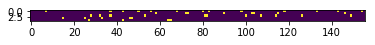

In [24]:
#Generar aleatoriamente entrada inicial

w = np.random.choice([0, 1], size=(tiempos_previos,156),  p=[0.95,0.05])
plt.imshow(w)

In [25]:
#Generar nueva cancion

tamano_cancion=200         #Numero de tiempos que tendra la cancion generada

u = np.zeros((1, tiempos_previos, 156), dtype=np.int32)
tamano_cancion=tamano_cancion+tiempos_previos
cancion_base=w
ent=np.zeros((tamano_cancion,156))
ent[0:tiempos_previos,:]=cancion_base
for i in tqdm(range (0,tamano_cancion-tiempos_previos)):			#Creacion de la cancion
    nueva_fila = model.predict(dimensionar(ent[i:i+tiempos_previos,:]), batch_size=1, verbose=1)
    if (np.all(np.round_(nueva_fila)==0)):
        nueva_fila[0,np.argsort(-nueva_fila)[0,:4]]=1
    ent[i+tiempos_previos] = nueva_fila
    ent=np.round_(ent)

ent=ent[tiempos_previos:tamano_cancion+tiempos_previos,:]

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s


  2%|█▏                                                                                | 3/200 [00:00<00:08, 22.71it/s]

1/1 [==============================] - 0s


  3%|██▍                                                                               | 6/200 [00:00<00:08, 22.69it/s]

1/1 [==============================] - 0s


  4%|███▋                                                                              | 9/200 [00:00<00:08, 23.01it/s]

1/1 [==============================] - 0s


  6%|████▍                                                                            | 11/200 [00:00<00:08, 21.79it/s]

1/1 [==============================] - 0s


  7%|█████▋                                                                           | 14/200 [00:00<00:08, 22.23it/s]

1/1 [==============================] - 0s


  8%|██████▉                                                                          | 17/200 [00:00<00:08, 22.68it/s]

1/1 [==============================] - 0s


 10%|████████                                                                         | 20/200 [00:00<00:07, 23.00it/s]

1/1 [==============================] - 0s


 12%|█████████▎                                                                       | 23/200 [00:01<00:07, 23.26it/s]

1/1 [==============================] - 0s


 13%|██████████▌                                                                      | 26/200 [00:01<00:07, 23.23it/s]

1/1 [==============================] - 0s


 14%|███████████▋                                                                     | 29/200 [00:01<00:07, 23.04it/s]

1/1 [==============================] - 0s


 16%|████████████▉                                                                    | 32/200 [00:01<00:07, 21.91it/s]

1/1 [==============================] - 0s


 18%|██████████████▏                                                                  | 35/200 [00:01<00:08, 19.68it/s]

1/1 [==============================] - 0s


 19%|███████████████▍                                                                 | 38/200 [00:01<00:07, 20.27it/s]

1/1 [==============================] - 0s


 20%|████████████████▌                                                                | 41/200 [00:01<00:07, 20.19it/s]

1/1 [==============================] - 0s


 22%|█████████████████▊                                                               | 44/200 [00:02<00:07, 20.71it/s]

1/1 [==============================] - 0s


 24%|███████████████████                                                              | 47/200 [00:02<00:07, 20.34it/s]

1/1 [==============================] - 0s


 25%|████████████████████▎                                                            | 50/200 [00:02<00:07, 20.95it/s]

1/1 [==============================] - 0s


 26%|█████████████████████▍                                                           | 53/200 [00:02<00:07, 21.00it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▋                                                          | 56/200 [00:02<00:07, 19.84it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▉                                                         | 59/200 [00:02<00:06, 20.14it/s]

1/1 [==============================] - 0s


 31%|█████████████████████████                                                        | 62/200 [00:02<00:06, 21.43it/s]

1/1 [==============================] - 0s


 32%|██████████████████████████▎                                                      | 65/200 [00:03<00:06, 22.19it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████▌                                                     | 68/200 [00:03<00:05, 22.57it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▊                                                    | 71/200 [00:03<00:05, 22.87it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▉                                                   | 74/200 [00:03<00:05, 23.58it/s]

1/1 [==============================] - 0s


 38%|███████████████████████████████▏                                                 | 77/200 [00:03<00:05, 22.96it/s]

1/1 [==============================] - 0s


 40%|████████████████████████████████▍                                                | 80/200 [00:03<00:05, 22.99it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▌                                               | 83/200 [00:03<00:04, 23.64it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▊                                              | 86/200 [00:03<00:04, 23.11it/s]

1/1 [==============================] - 0s


 44%|████████████████████████████████████                                             | 89/200 [00:04<00:04, 23.47it/s]

1/1 [==============================] - 0s


 46%|█████████████████████████████████████▎                                           | 92/200 [00:04<00:04, 23.79it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████▍                                          | 95/200 [00:04<00:04, 23.70it/s]

1/1 [==============================] - 0s


 49%|███████████████████████████████████████▋                                         | 98/200 [00:04<00:04, 23.23it/s]

1/1 [==============================] - 0s


 50%|████████████████████████████████████████▍                                       | 101/200 [00:04<00:04, 23.07it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:04<00:04, 23.23it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:04<00:03, 23.73it/s]

1/1 [==============================] - 0s


 55%|████████████████████████████████████████████                                    | 110/200 [00:04<00:03, 23.52it/s]

1/1 [==============================] - 0s


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:05<00:03, 23.14it/s]

1/1 [==============================] - 0s


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:05<00:03, 22.34it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:05<00:03, 22.20it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:05<00:03, 20.95it/s]

1/1 [==============================] - 0s


 62%|██████████████████████████████████████████████████                              | 125/200 [00:05<00:03, 22.11it/s]

1/1 [==============================] - 0s


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:05<00:03, 22.07it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:05<00:03, 22.33it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:06<00:02, 22.52it/s]

1/1 [==============================] - 0s


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:06<00:02, 22.53it/s]

1/1 [==============================] - 0s


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:06<00:02, 22.87it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:06<00:02, 23.06it/s]

1/1 [==============================] - 0s


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:06<00:02, 23.49it/s]

1/1 [==============================] - 0s


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:06<00:02, 21.59it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:06<00:02, 22.43it/s]

1/1 [==============================] - 0s


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:06<00:01, 22.67it/s]

1/1 [==============================] - 0s


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:07<00:01, 23.59it/s]

1/1 [==============================] - 0s


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:07<00:01, 23.94it/s]

1/1 [==============================] - 0s


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:07<00:01, 22.85it/s]

1/1 [==============================] - 0s


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:07<00:01, 23.13it/s]

1/1 [==============================] - 0s


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [00:07<00:01, 22.66it/s]

1/1 [==============================] - 0s


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [00:07<00:01, 22.63it/s]

1/1 [==============================] - 0s


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [00:07<00:01, 22.91it/s]

1/1 [==============================] - 0s


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [00:07<00:00, 22.77it/s]

1/1 [==============================] - 0s


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [00:08<00:00, 22.91it/s]

1/1 [==============================] - 0s


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [00:08<00:00, 22.77it/s]

1/1 [==============================] - 0s


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [00:08<00:00, 21.98it/s]

1/1 [==============================] - 0s


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:08<00:00, 22.67it/s]

1/1 [==============================] - 0s


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [00:08<00:00, 21.79it/s]

1/1 [==============================] - 0s


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [00:08<00:00, 22.48it/s]

1/1 [==============================] - 0s


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.60it/s]


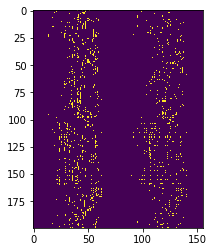

In [26]:
plt.imshow(ent)

In [27]:
#Guardar archivo midi

manipulacion_midi.noteStateMatrixToMidi(ent, "./cancion_generada4")